In [1]:
'''Train a simple deep CNN on the CIFAR10 small images dataset.
It gets to 75% validation accuracy in 25 epochs, and 79% after 50 epochs.
(it's still underfitting at that point, though).
'''

"Train a simple deep CNN on the CIFAR10 small images dataset.\nIt gets to 75% validation accuracy in 25 epochs, and 79% after 50 epochs.\n(it's still underfitting at that point, though).\n"

In [2]:
from __future__ import print_function
import keras
import os
import json
import matplotlib.pyplot as plt
import datetime
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from time import time
from keras.callbacks import TensorBoard


C:\Anaconda\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import matplotlib
#%matplotlib inline
#matplotlib.style.use('ggplot')

In [4]:
# Create logfile.
logfile = open("logs/Cifar10_CNN.log", "a")
def log_entry(s):
    #print('Date now: %s' % datetime.datetime.now())

    timestamp = '[%s] : ' % datetime.datetime.now()
    log_line = timestamp + s + '\n'
    logfile.write(log_line)
    logfile.flush()

In [5]:
def parseFloat(x):
    try:
        x = float(x)
    except:
        x = 0
        log_entry("Unable to conveert ot float")
    return x

def convertToInt(x):
    try:
        x = int(x)
    except:
        x = 0
        log_entry("Unable to conveert ot int")
    return x

In [6]:
class Histories(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.aucs = []
        self.losses = []
    def on_train_end(self, logs={}):
        return
    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        y_pred = self.model.predict(self.model.validation_data[0])
        self.aucs.append(roc_auc_score(self.model.validation_data[1], y_pred))
        return
    def on_batch_begin(self, batch, logs={}):
        return
    def on_batch_end(self, batch, logs={}):
        return

In [7]:
#Start program by loading json file
#log_entry("Reading json file")

#read parameters from config file
with open('config/config.json') as json_file:    
        json_data = json.load(json_file)

log_entry("Json file loaded")

In [8]:
batch_size = convertToInt(json_data["batch_size"])
num_classes = convertToInt(json_data["num_classes"])
epochs = convertToInt(json_data["epochs"])
data_augmentation = json_data["data_augmentation"]
num_predictions = convertToInt(json_data["num_predictions"])
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

In [9]:
# The data, shuffled and split between train and test sets:
log_entry("Loading dataset")
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [10]:
# Convert class vectors to binary class matrices.
log_entry("Convert class vectors to binary class matrices")
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [11]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [12]:
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [13]:
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [14]:
# initiate RMSprop optimizer
log_entry("# initiate RMSprop optimizer")
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

In [15]:
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [16]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [17]:
log_entry("start training model")
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    tensorboard = TensorBoard(log_dir="logs/{}".format(time()),histogram_freq=0,write_graph=True, write_images=True)
    
    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4, callbacks=[tensorboard])

Using real-time data augmentation.
Epoch 1/10
1563/1563 [==============================] - 399s 255ms/step - loss: 1.8555 - acc: 0.3156 - val_loss: 1.5939 - val_acc: 0.4238
Epoch 2/10
1563/1563 [==============================] - 390s 249ms/step - loss: 1.5626 - acc: 0.4290 - val_loss: 1.3629 - val_acc: 0.5067
Epoch 3/10
1563/1563 [==============================] - 390s 249ms/step - loss: 1.4357 - acc: 0.4826 - val_loss: 1.2452 - val_acc: 0.5595
Epoch 4/10
1563/1563 [==============================] - 402s 257ms/step - loss: 1.3357 - acc: 0.5217 - val_loss: 1.1815 - val_acc: 0.5793
Epoch 5/10
1563/1563 [==============================] - 400s 256ms/step - loss: 1.2652 - acc: 0.5472 - val_loss: 1.0806 - val_acc: 0.6183
Epoch 6/10
1563/1563 [==============================] - 398s 255ms/step - loss: 1.2094 - acc: 0.5697 - val_loss: 1.1011 - val_acc: 0.6062
Epoch 7/10
1563/1563 [==============================] - 406s 260ms/step - loss: 1.1535 - acc: 0.5904 - val_loss: 0.9864 - val_acc: 0.6585

In [18]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

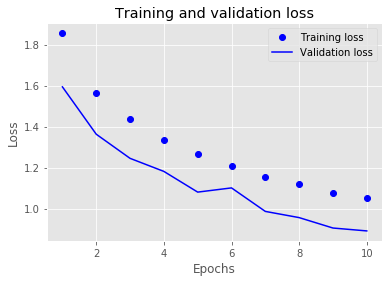

In [19]:


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


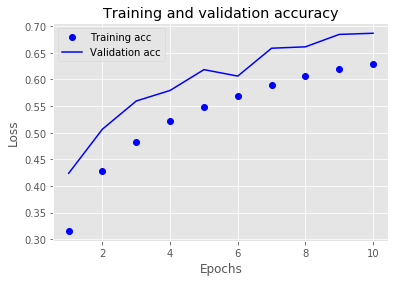

In [20]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [21]:
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Data\Important\Study\Cognitive\Assignments\Assignment1\saved_models\keras_cifar10_trained_model.h5 


In [22]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 30s 3ms/step
Test loss: 0.8912635199546814
Test accuracy: 0.6866
